<a href="https://colab.research.google.com/github/HasithaIndrajith/FYP/blob/main/GNN_OBLR_Zymo_190277L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%writefile install.sh
current=$(pwd)

# download boost
wget https://boostorg.jfrog.io/artifactory/main/release/1.77.0/source/boost_1_77_0.tar.gz
tar -xf boost_1_77_0.tar.gz

# install boost
cd boost_1_77_0

./bootstrap.sh --with-libraries=program_options,iostreams
./b2 install

cd $current

Writing install.sh


In [ ]:
!sh install.sh &> /dev/null

In [ ]:
%%writefile install-prereq.sh

# install seqtk
current=$(pwd)
git clone https://github.com/lh3/seqtk.git;
cd seqtk; make

# install wtdbg2
cd $current
git clone https://github.com/ruanjue/wtdbg2
cd wtdbg2 && make

# install seq2vec
cd $current
git clone https://github.com/anuradhawick/seq2vec.git
cd seq2vec
./build.sh

Writing install-prereq.sh


In [ ]:
!sh install-prereq.sh &> /dev/null

In [ ]:
!mkdir test_data
!gdown https://drive.google.com/uc?id=1-2c901K7afLjlW82Ms1sumyGCkY3q7tx -O test_data/reads.fasta
!gdown https://drive.google.com/uc?id=1-8_Upcls8FCMOXb7mjZyyqr1rWhhd17P -O test_data/ground_truth.txt

Downloading...
From (original): https://drive.google.com/uc?id=1-2c901K7afLjlW82Ms1sumyGCkY3q7tx
From (redirected): https://drive.google.com/uc?id=1-2c901K7afLjlW82Ms1sumyGCkY3q7tx&confirm=t&uuid=786d335a-7ca1-4329-af26-7f6f038a0771
To: /content/test_data/reads.fasta
100% 3.25G/3.25G [00:37<00:00, 86.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-8_Upcls8FCMOXb7mjZyyqr1rWhhd17P
To: /content/test_data/ground_truth.txt
100% 5.27M/5.27M [00:00<00:00, 50.2MB/s]


In [ ]:
exp = "./test_data/"

In [ ]:
# !./seqtk/seqtk rename $exp/reads.fastq read_ | ./seqtk/seqtk seq -A > $exp/reads.fasta

In [ ]:
!grep ">" $exp/reads.fasta > $exp/read_ids

In [ ]:
!./seq2vec/build/seq2vec -k 4 -o $exp/4mers -f $exp/reads.fasta -t 16

Starting Seq2Vec sequence vectorization: TSV output
Counting sequences
154312 sequences found
Completed 100.00%       


In [ ]:
%%writefile filter_alignments.py

import sys
import fileinput
import gzip
import numpy as np

path = "./"

if len(sys.argv) == 2:
    path = sys.argv[1] + "/"

class Alignment:
    def __init__(self, line):
        """
        COL1 qry_name
        COL2 qry_strand
        COL3 qry_length
        COL4 qry_beg
        COL5 qry_end
        COL6 ref_name
        COL7 ref_strand (always equals +)
        COL8 ref_length
        COL9 ref_beg
        COL10 ref_end
        COL11 match_len (length of matched k-mers)
        COL12 align_len (length of aligned)
        COL13 #kcnt (number of matched k-mers)
        COL14 #gap (number of gapped BINs)
        COL15 cigar (256 x SAM's cigar)
        """
        data = line.strip().split("\t")
        self.raw_data = line.strip()
        self.qry_name = data[0]
        self.qry_strand = data[1]
        self.qry_length = int(data[2])
        self.qry_beg = int(data[3])
        self.qry_end = int(data[4])
        self.ref_name = data[5]
        self.ref_strand = data[6]
        self.ref_length = int(data[7])
        self.ref_beg = int(data[8])
        self.ref_end = int(data[9])
        self.match_len = int(data[10])
        self.align_len = int(data[11])
        self.kmers = int(data[12])
        self.gap = int(data[13])


def is_overlap(alignment):
    qry_beg = alignment.qry_beg
    qry_end = alignment.qry_end
    ref_beg = alignment.ref_beg
    ref_end = alignment.ref_end
    qry_length = alignment.qry_length
    ref_length = alignment.ref_length

    THRESHOLD = 512

    # full overlap
    if qry_beg <= THRESHOLD and qry_length - qry_end <= THRESHOLD:
        return True
    elif ref_beg <= THRESHOLD and ref_length - ref_end <= THRESHOLD:
        return True

    # qry end overlap
    if qry_length - qry_end <= THRESHOLD and ref_beg <= THRESHOLD:
        return True
    # ref end overlap
    elif ref_length - ref_end <= THRESHOLD and qry_beg <= THRESHOLD:
        return True

    return False

def process_batch(alignments, fpe, fpd):
    # skip alignments that are self, this can cause total failure
    # skip non overlaps
    alignments = [a for a in alignments if is_overlap(a) and a.qry_name!=a.ref_name]
    # exit if empty (first scenario)
    if len(alignments) == 0:
        return

    # compute alignment overlaps
    alignments = sorted(alignments, key=lambda a: a.match_len, reverse=True)
    match_lengths = [a.match_len for a in alignments]
    mean_match = np.mean(match_lengths)

    degree = 0
    for n, a in enumerate(alignments):
        # record actual edge count
        degree += 1

        # write only top 20 edges
        if n < 20:
            fpe.write(f"{a.qry_name}\t{a.ref_name}\n")

    fpd.write(f"{alignments[0].qry_name}\t{degree}\n")

active_query = None
alns_buffer = []
out_file_edges = open(path + 'reads.alns', 'w+')
out_file_degree = open(path + 'degree', 'w+')

for line in fileinput.input('-'):
    if len(line.strip()) == 1:
        continue

    alignment = Alignment(line)

    if alignment.qry_name != active_query:
        # new query
        # if there is a previous query process it
        if len(alns_buffer) > 0:
            process_batch(alns_buffer, out_file_edges, out_file_degree)
            # sys.exit(0)

        # reset buffers
        active_query = alignment.qry_name
        alns_buffer = [alignment]
    else:
        alns_buffer.append(alignment)

if len(alns_buffer) > 0:
    process_batch(alns_buffer, out_file_edges, out_file_degree)

out_file_edges.close()
out_file_degree.close()

Writing filter_alignments.py


In [ ]:
!./wtdbg2/kbm2  -i $exp/reads.fasta -d $exp/reads.fasta -n 2000 -l 2560 -t 16 | python filter_alignments.py $exp/

# please refer to chunked version in GitHub for a more memory conservative graph construction.

--
-- total memory       13290480.0 kB
-- available          11813808.0 kB
-- 2 cores
-- Starting program: ./wtdbg2/kbm2 -i ./test_data//reads.fasta -d ./test_data//reads.fasta -n 2000 -l 2560 -t 16
-- pid                     70324
-- date         Fri Jan 26 15:16:53 2024
--
[Fri Jan 26 15:16:53 2024] loading sequences
154312 reads
[Fri Jan 26 15:17:13 2024] Done, 154312 reads, 3168020167 bp, 12298076 bins
[Fri Jan 26 15:17:13 2024] indexing, 16 threads
[Fri Jan 26 15:17:13 2024] - scanning kmers (K0P21S4.00) from 12298076 bins
12298076 bins
** PROC_STAT(0) **: real 291.239 sec, user 425.180 sec, sys 16.820 sec, maxrss 4466088.0 kB, maxvsize 5688536.0 kB
[Fri Jan 26 15:21:44 2024] - high frequency kmer depth is set to 1000
[Fri Jan 26 15:21:46 2024] - Total kmers = 180629012
[Fri Jan 26 15:21:46 2024] - average kmer depth = 2
[Fri Jan 26 15:21:46 2024] - 0 low frequency kmers (<1)
[Fri Jan 26 15:21:46 2024] - 276 high frequency kmers (>1000)
[Fri Jan 26 15:21:46 2024] - indexing 180628

In [ ]:
# !cp /content/test_data/4mers /content/drive/MyDrive/test_data_zymo
# !cp /content/test_data/degree /content/drive/MyDrive/test_data_zymo
# !cp /content/test_data/reads.alns /content/drive/MyDrive/test_data_zymo
# !cp /content/test_data/read_ids /content/drive/MyDrive/test_data_zymo

In [ ]:
!pip install umap-learn
!pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=968806bfb4adfffd1dc8f43d81ac31bdfd1e3bb7f4312fca91399d7ddbd80572
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
  Cloning https://github.com/scikit-learn-contrib/hdbscan.git to /tmp/pip-install-2ghtx9jt/hdbscan_91221a4f079b48f58fb2dd96182a9e08
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/hdbscan.git /tmp/pip-install-2ghtx9jt/hdbscan_91221a4f079b48f58fb2dd96182a9e08
  Resolved https://github.com/scikit-learn-contrib/hdbscan.git to commit 98928d0c095715edc9584e7989bd8559673bc2f0
  Installing build dependencies ... done
  Getting requirements to build wheel ... d

In [ ]:
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from  tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd

try:
    from cuml.manifold import UMAP
    from cuml.metrics.cluster.silhouette_score import cython_silhouette_score as silhouette_score
    from cuml.cluster import HDBSCAN
    print('Using CUML')
except Exception as e:
    from sklearn.metrics import silhouette_score
    from umap import UMAP
    from hdbscan import HDBSCAN
    print('Using SciPy', e)

Using SciPy No module named 'cuml'


In [ ]:
exp = "./test_data/"

alignments_file_path = exp + "reads.alns"
degrees_file_path = exp + "degree"

comp = pd.read_csv(exp + "4mers", header=None).to_numpy()

try:
    truth = np.array(open(exp + "ground_truth.txt").read().strip().split("\n"))
except:
    truth = np.array([str(0) for x in range(len(comp))])
reads = exp + "reads.fasta"

In [ ]:
# read_id_idx = {}

def get_palette(labels):
    palette = {x: f'C{n}' for n, x in enumerate(sorted(set(labels) - {-1, '-1', 'Unknown', 'unknown'}))}
    palette['Unknown'] = 'white'
    palette['-1'] = 'white'
    palette[-1] = 'white'

    return palette


def get_idx_maps(read_ids_file_path, truth):
    reads_truth = {}
    read_id_idx = {}
    # global read_id_idx
    with open(read_ids_file_path) as read_ids_file:
        for t, rid in tqdm(zip(truth, read_ids_file)):
            rid = rid.strip().split()[0][1:]
            reads_truth[rid] = t
            read_id_idx[rid] = len(read_id_idx)

    return reads_truth, read_id_idx


def load_read_degrees(degrees_file_path,read_id_idx):
    degree_array = np.zeros_like(truth, dtype=int)
    for line in tqdm(open(degrees_file_path, 'r')):
        i, d = line.strip().split()
        d = int(d)
        print(degree_array)
        degree_array[read_id_idx[i]] = d

    return degree_array


def alignments_to_edges(alignments_file_path, edges_txt_path, read_id_idx, reads_truth):
    TP = 0
    FP = 0

    if not os.path.isfile(edges_txt_path):
        with open(edges_txt_path, "w+") as ef:
            for line in tqdm(open(alignments_file_path, "r")):
                u, v = line.strip().split('\t')

                if u == v:
                    continue

                ef.write(f"{read_id_idx[u]}\t{read_id_idx[v]}\n")

                if reads_truth[u] == 'Unknown' or reads_truth[v] == 'Unknown':
                    continue
                if reads_truth[u] == reads_truth[v]:
                    TP += 1
                else:
                    FP += 1
    return TP, FP


def load_edges_as_numpy(edges_txt_path, edges_npy_path):
    if not os.path.isfile(edges_npy_path):
        edges_txt = [x.strip() for x in tqdm(open(edges_txt_path))]
        edges = np.zeros((len(edges_txt), 2), dtype=np.int32)

        for i in tqdm(range(len(edges_txt))):
            e1, e2 = edges_txt[i].strip().split()
            edges[i]  = [int(e1), int(e2)]

        np.save(edges_npy_path, edges)

    return np.load(edges_npy_path)


def plot_degree_hist(degree, path=None):
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 16})

    sns.histplot(degree_array[degree_array>1], binwidth=5) # it must be more than 1 (can have self edges)
    plt.ylabel('No. of Vertices', fontsize=18)
    plt.xlabel('Degree', fontsize=18)

    if path is not None:
        plt.savefig(path, dpi=1200, bbox_inches = 'tight')
    else:
        plt.show()


def plot_umap(embedding, labels, palette=None, path=None, paper=False):
    plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 16})
    plt.ylabel('UMAP 2', fontsize=18)
    plt.xlabel('UMAP 1', fontsize=18)

    if path is not None and not paper:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
        plt.savefig(path, dpi=1200, bbox_inches = 'tight')
    if path is not None and paper:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette, legend=False)
        plt.savefig(path.replace('.pdf', '-paper.pdf'), dpi=1200, bbox_inches = 'tight')
    else:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")


def get_highest_scoring_clustering(data, size):
    best_score = -1
    best_clusters = None
    best_size = -1

    try:
        clusters = HDBSCAN(min_cluster_size=size).fit_predict(data)
        if len(set(clusters) - {1}) == 0:
            return None, -1, None
        score = silhouette_score(data[clusters!=-1], clusters[clusters!=-1])

        print(size, score)
    except:
        pass

    if score > best_score:
        best_score = score
        best_clusters = clusters
        best_size = size

    return best_size, best_score, best_clusters


def get_best_embedding(data, weights):
    best_size = None
    best_sample_size = None
    best_sample_idx = None
    best_score = -1
    best_clusters = None
    best_embedding = None
    best_cluster_count = None

    for sample_size in [25000, 50000, 100000]:
        print(f'Scanning sample size {sample_size}')
        sample_idx = np.random.choice(range(len(data)), size=sample_size, replace=False, p=weights/weights.sum())
        sampled_data = data[sample_idx]
        embedding = UMAP().fit_transform(sampled_data)
        size, score, clusters = get_highest_scoring_clustering(embedding, 500)
        count = len(set(clusters) - {-1})

        print(f'Cluster size = {size:5} Clusters = {count:5} Score = {score:1.5f}')

        if score > best_score:
            best_cluster_count = count
            best_size = size
            best_sample_size = sample_size
            best_score = score
            best_clusters = clusters
            best_embedding = embedding
            best_sample_idx = sample_idx

    return best_size, best_sample_size, best_score, best_clusters, best_cluster_count, best_embedding, best_sample_idx


def rename_clusters(clusters):
    rename_map = {k:n for n, k in enumerate(set(clusters) - {-1})}
    rename_map[-1] = -1

    clusters = np.array([rename_map[x] for x in clusters])

    return clusters

154312it [00:01, 106966.86it/s]
298it [00:00, 2893.36it/s]

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[ 0  0 88 ...  0  0  0]
[ 0  0 88 ...  0  0  0]
[ 0  0 88 ...  0  0  0]
[ 0  0 88 ...  0  0  0]
[ 0  0 88 ...  0  0  0]
[ 0  0 88 ...  0  0  0]
[ 0  0 88 ...  0  0  0]
[109   0  88 ...   0   0   0]
[109   0  88 ...   0   0   0]
[109   0  88 ...   0   0   0]
[109   0  88 ...   0   0   0]
[109   0  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0

1135it [00:00, 2690.07it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

1405it [00:00, 2396.72it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

1956it [00:00, 2183.53it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

2194it [00:00, 2052.28it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

2969it [00:01, 2300.44it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

3506it [00:01, 2255.97it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

4136it [00:01, 2720.22it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

4823it [00:01, 3094.50it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

5487it [00:02, 3135.00it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

5804it [00:02, 2783.77it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

6357it [00:02, 2254.25it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

6863it [00:02, 2024.48it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

7379it [00:03, 2225.92it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

7897it [00:03, 2261.15it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

8356it [00:03, 1930.73it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

8744it [00:03, 1719.04it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

9089it [00:04, 1576.44it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

9495it [00:04, 1708.07it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

9986it [00:04, 2043.31it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

10832it [00:04, 2322.70it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

11093it [00:04, 2257.38it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

11879it [00:05, 2423.10it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

12526it [00:05, 2773.88it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

13119it [00:05, 2751.95it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

13750it [00:05, 2887.96it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

14313it [00:06, 2282.47it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

14825it [00:06, 2084.74it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

15043it [00:06, 1983.80it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

15439it [00:06, 1644.06it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

15959it [00:07, 1981.72it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

16419it [00:07, 1921.86it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

16903it [00:07, 2161.06it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

17806it [00:07, 2456.25it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

18407it [00:08, 2471.73it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

18667it [00:08, 1893.57it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

19140it [00:08, 2068.92it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

19643it [00:08, 2059.98it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

20530it [00:09, 2476.92it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

21050it [00:09, 2523.26it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

21307it [00:09, 2043.12it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

22098it [00:09, 2143.72it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

22561it [00:10, 2210.23it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

23259it [00:10, 2151.86it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

23728it [00:10, 2132.25it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

24187it [00:10, 2069.41it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

24397it [00:11, 1559.02it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

24813it [00:11, 1626.69it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

25443it [00:11, 1734.60it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

25953it [00:11, 1995.14it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

26619it [00:12, 2028.42it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

27124it [00:12, 2261.11it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

27558it [00:12, 1844.81it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

28187it [00:13, 1724.54it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

28590it [00:13, 1682.33it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

29315it [00:13, 2118.18it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

29729it [00:14, 1777.29it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

30378it [00:14, 1911.52it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

30759it [00:14, 1831.07it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

31216it [00:14, 1887.45it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

31613it [00:15, 1663.41it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

32085it [00:15, 1341.99it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

32412it [00:15, 1444.64it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

32917it [00:15, 1546.19it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

33286it [00:16, 1424.52it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

33710it [00:16, 1724.37it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

34455it [00:16, 2096.07it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

34966it [00:17, 2252.37it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

35195it [00:17, 1934.76it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

35613it [00:17, 1579.33it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

36091it [00:17, 1844.13it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

36686it [00:18, 1841.01it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

37416it [00:18, 2660.18it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

38134it [00:18, 1889.60it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

38546it [00:18, 1926.75it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

39095it [00:19, 2293.69it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

39669it [00:19, 2475.26it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

40517it [00:19, 2616.67it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

41086it [00:19, 2639.01it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

41739it [00:20, 2886.96it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

42373it [00:20, 2669.19it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

43052it [00:20, 2456.69it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

43703it [00:20, 2806.53it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

44251it [00:21, 1946.28it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

45069it [00:21, 2188.61it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

45587it [00:21, 2045.39it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

46320it [00:22, 2005.17it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

46919it [00:22, 1754.06it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

47342it [00:22, 1791.36it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

48249it [00:23, 2592.63it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

48873it [00:23, 2813.36it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

49660it [00:23, 2319.15it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

50120it [00:23, 1941.26it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

50769it [00:24, 1855.03it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

51213it [00:24, 1803.69it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

51570it [00:24, 1534.23it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

52028it [00:25, 1607.59it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

52702it [00:25, 1909.75it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

53564it [00:25, 2536.38it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

54252it [00:25, 2759.68it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

54802it [00:26, 2280.30it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

55547it [00:26, 2053.68it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

55948it [00:26, 1815.20it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

56654it [00:27, 1963.84it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

57237it [00:27, 1727.85it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

57848it [00:27, 1842.76it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

58740it [00:28, 2436.83it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

59219it [00:28, 2212.88it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

60025it [00:28, 1816.07it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

60382it [00:29, 1450.04it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

60885it [00:29, 1520.44it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

61297it [00:29, 1763.10it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

61953it [00:30, 1933.54it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

62719it [00:30, 2091.85it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

63138it [00:30, 1721.24it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

64187it [00:31, 2278.65it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

64985it [00:31, 2500.09it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

65736it [00:31, 2281.17it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

66159it [00:32, 1531.34it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

66646it [00:32, 1807.05it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

67425it [00:32, 1844.22it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

68029it [00:33, 1865.99it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

68613it [00:33, 1866.32it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

69179it [00:33, 1752.56it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

69841it [00:34, 1898.40it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

70627it [00:34, 1807.99it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

71204it [00:35, 1637.21it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

71812it [00:35, 1728.68it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

72311it [00:35, 1537.63it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

72856it [00:36, 1646.59it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

73584it [00:36, 2018.68it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

74525it [00:36, 2158.69it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

75167it [00:37, 2057.63it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

75943it [00:37, 1860.85it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

76530it [00:37, 1822.89it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

77347it [00:38, 2275.75it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

77990it [00:38, 2615.14it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

78786it [00:38, 2324.05it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

79701it [00:39, 2708.48it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

80731it [00:39, 3004.41it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

81759it [00:39, 3148.88it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

82450it [00:39, 3206.94it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

83379it [00:40, 2346.73it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

84208it [00:40, 2454.17it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

84696it [00:41, 1910.24it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

85451it [00:41, 2078.22it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

86160it [00:41, 2083.90it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

86793it [00:42, 1790.59it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

87575it [00:42, 2769.19it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

88148it [00:42, 2571.33it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

88833it [00:42, 2791.04it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

90017it [00:43, 3359.52it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

91256it [00:43, 3650.85it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

92056it [00:43, 3750.12it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

93357it [00:43, 4072.13it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

94198it [00:44, 4001.35it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

95349it [00:44, 3512.95it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

96195it [00:44, 3283.16it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

96998it [00:45, 3602.73it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

97750it [00:45, 3599.90it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

98907it [00:45, 3536.87it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

99313it [00:45, 3269.73it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

100356it [00:46, 2640.10it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

101000it [00:46, 2529.45it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

101746it [00:46, 2933.64it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

102059it [00:47, 1542.61it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

103002it [00:47, 1943.09it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

103983it [00:47, 2662.39it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

104939it [00:48, 2806.27it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

106329it [00:48, 3243.69it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

107004it [00:48, 3186.83it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

107408it [00:49, 3340.05it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

107744it [00:49, 1086.96it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

108938it [00:50, 1553.60it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

109195it [00:51, 998.59it/s] 


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

109390it [00:51, 778.04it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

109540it [00:52, 685.34it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

109659it [00:52, 668.64it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

109760it [00:52, 573.85it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

109841it [00:52, 500.40it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

109966it [00:53, 438.32it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

110238it [00:53, 684.52it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

111302it [00:53, 2120.94it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

112293it [00:54, 2834.20it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

113372it [00:54, 3225.04it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

114384it [00:54, 3162.80it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

115387it [00:55, 3060.56it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

116616it [00:55, 3566.18it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

117713it [00:55, 3355.77it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

118920it [00:55, 3723.18it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

119294it [00:56, 2569.61it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

120411it [00:56, 3156.12it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

121521it [00:56, 3284.43it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

122539it [00:57, 3023.79it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

122849it [00:57, 1579.48it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

123276it [00:58, 1335.37it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

123461it [00:58, 1000.51it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

124321it [00:58, 1646.64it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

124885it [00:59, 2061.82it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

126332it [00:59, 3114.35it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

127084it [00:59, 3382.26it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

127461it [00:59, 3353.82it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

127803it [01:00, 1515.54it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

128810it [01:00, 2073.04it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

130011it [01:01, 2277.65it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

131107it [01:01, 2985.72it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

131783it [01:01, 2465.40it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

132860it [01:02, 2941.85it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

133949it [01:02, 3301.38it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

135389it [01:03, 3452.44it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

136537it [01:03, 3577.48it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

137628it [01:03, 3525.91it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

138743it [01:03, 3612.31it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

139773it [01:04, 3204.74it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

140832it [01:04, 3368.83it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

142266it [01:05, 3424.65it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

143029it [01:05, 3624.77it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

144055it [01:05, 2964.17it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

144653it [01:06, 1732.89it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

145422it [01:06, 1932.03it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

146585it [01:07, 1318.67it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

147293it [01:07, 1745.35it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

148175it [01:08, 2422.01it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

149023it [01:08, 1548.98it/s]

[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  

149822it [01:08, 2108.05it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

150728it [01:09, 2641.65it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

152101it [01:09, 3267.49it/s]


[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

153096it [01:09, 2187.80it/s]



[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148  88 ...   0   0   0]
[109 148 

2959384it [00:52, 56856.52it/s]


Precision of reads (if ground truth provided) 11.695913744172111


2959384it [00:06, 435602.80it/s] 
100%|██████████| 2959384/2959384 [00:09<00:00, 318316.83it/s]


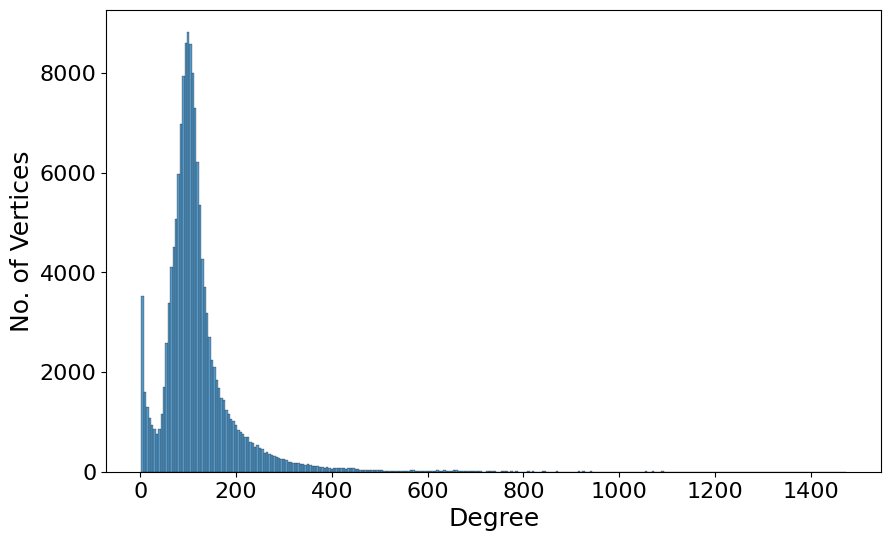

In [ ]:
palette = get_palette(truth)
reads_truth, read_id_idx = get_idx_maps(exp + 'read_ids', truth)
degree_array = load_read_degrees(degrees_file_path,read_id_idx)
TP, FP = alignments_to_edges(alignments_file_path, exp + "edges.txt", read_id_idx, reads_truth)

print("Precision of reads (if ground truth provided)", 100 * TP/ (TP+FP + 1e-5))

edges = load_edges_as_numpy(exp + "edges.txt", exp + "edges.npy")
sample_weights = np.zeros_like(degree_array, dtype=np.float32)
sample_scale = np.ones_like(degree_array, dtype=np.float32)

plot_degree_hist(degree_array)

In [ ]:
for n, d in enumerate(degree_array):
    sample_weights[n] = 1.0/d if d>0 else 0
    sample_scale[n] = max(1, np.log10(max(1, d)))

scaled = comp * sample_scale.reshape(-1, 1)

In [ ]:
results = []

for i in range(5):
    t_size, t_sample_size, t_score, t_clusters, t_cluster_count, t_embedding, t_sample_idx = get_best_embedding(scaled, sample_weights)

    results.append([t_size, t_sample_size, t_score, t_clusters, t_cluster_count, t_embedding, t_sample_idx])

Scanning sample size 25000
500 0.68413526
Cluster size =   500 Clusters =     8 Score = 0.68414
Scanning sample size 50000
500 0.7168832
Cluster size =   500 Clusters =    10 Score = 0.71688
Scanning sample size 100000
500 0.62253636
Cluster size =   500 Clusters =    11 Score = 0.62254
Scanning sample size 25000
500 0.71482545
Cluster size =   500 Clusters =     8 Score = 0.71483
Scanning sample size 50000
500 0.67819005
Cluster size =   500 Clusters =    11 Score = 0.67819
Scanning sample size 100000
500 0.62951404
Cluster size =   500 Clusters =    11 Score = 0.62951
Scanning sample size 25000
500 0.7258945
Cluster size =   500 Clusters =     8 Score = 0.72589
Scanning sample size 50000
500 0.69412214
Cluster size =   500 Clusters =    10 Score = 0.69412
Scanning sample size 100000
500 0.6156403
Cluster size =   500 Clusters =     9 Score = 0.61564
Scanning sample size 25000
500 0.7111532
Cluster size =   500 Clusters =     8 Score = 0.71115
Scanning sample size 50000
500 0.6810132


In [ ]:
size, sample_size, score, clusters, cluster_count, embedding, sample_idx = None, None, -1, None, 0, None, None

cluster_counts = Counter([result[4] for result in results])
cluster_counts = sorted(cluster_counts.most_common(), key=lambda x: (x[1], x[0]), reverse=True)
chose = cluster_counts[0][0]

print(f"Count stats = {cluster_counts}")
print(f'Maximally occuring cluster count = {chose}')

for result in results:
    if result[4] == chose and result[2] > score:
        size, sample_size, score, clusters, cluster_count, embedding, sample_idx = result

Count stats = [(8, 3), (10, 1), (9, 1)]
Maximally occuring cluster count = 8


In [ ]:
print(f'Chosen Score = {score:3.4f} Sample_size = {sample_size:5} Size = {size} Clusters = {cluster_count}')

Chosen Score = 0.7259 Sample_size = 25000 Size = 500 Clusters = 8


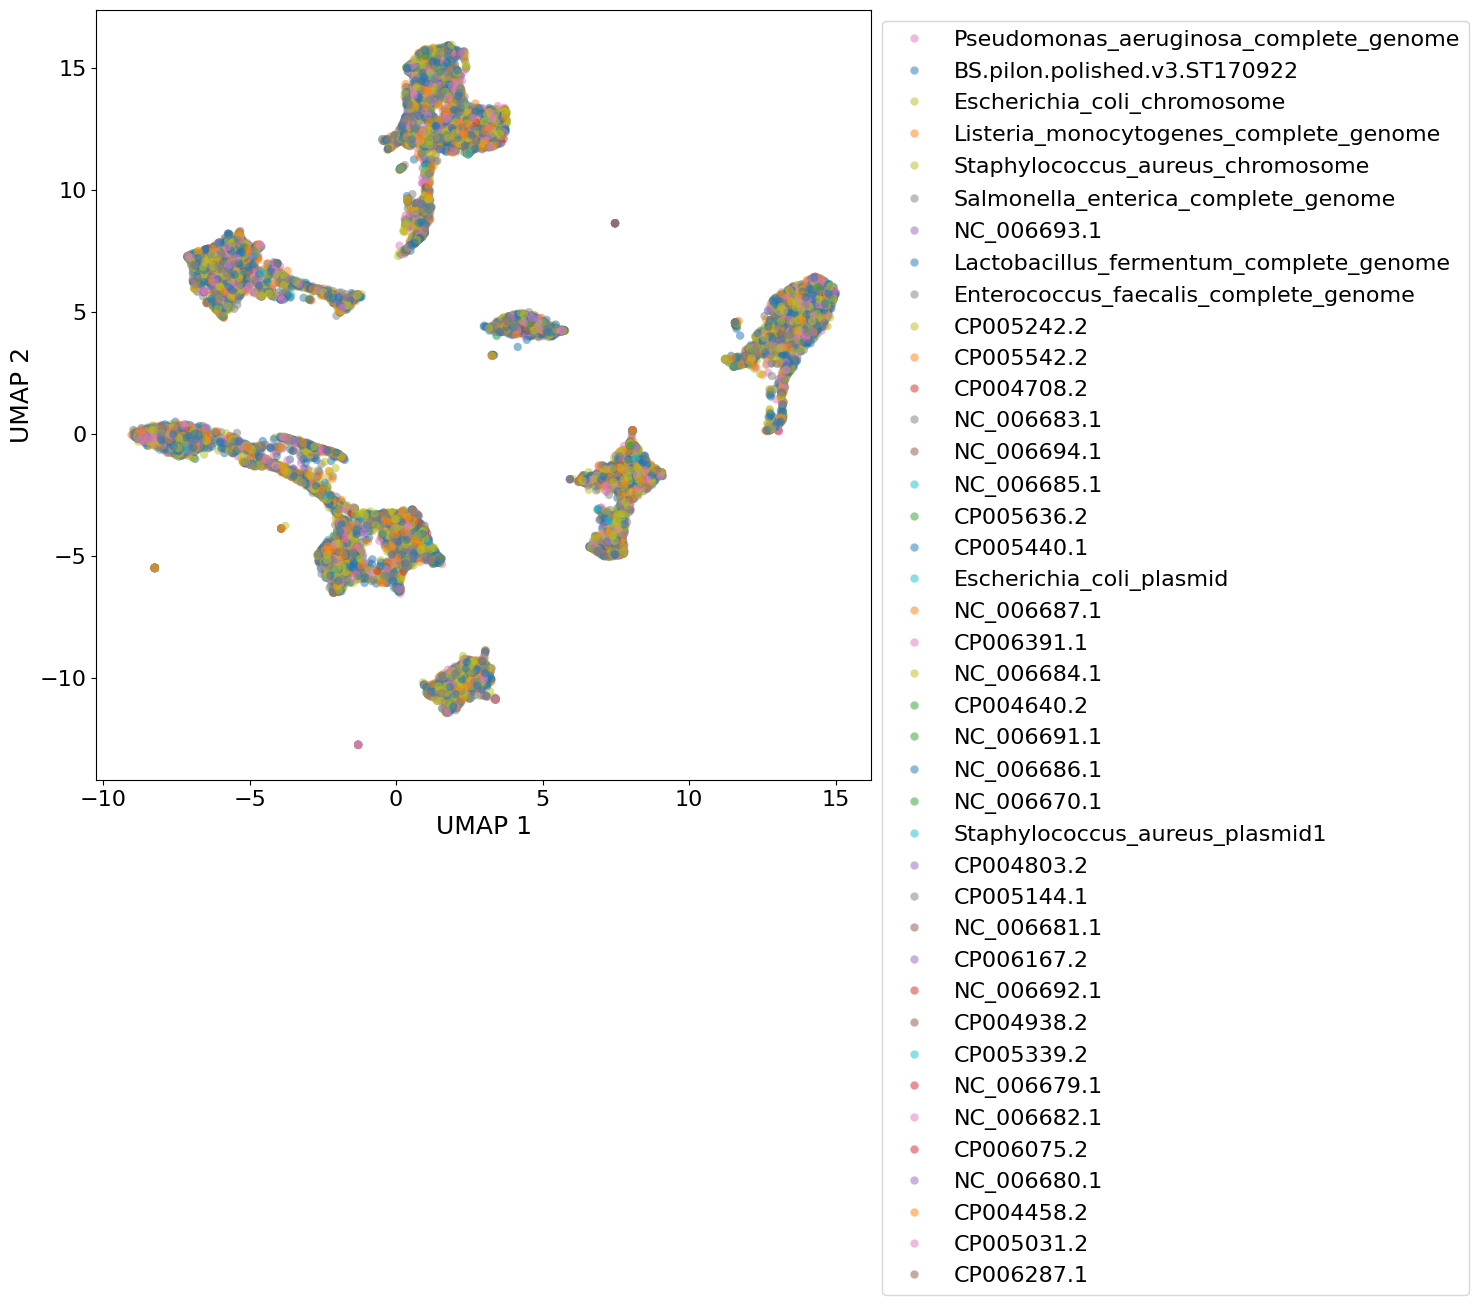

In [ ]:
plot_umap(embedding, truth[sample_idx], palette)

In [ ]:
clusters = rename_clusters(clusters)

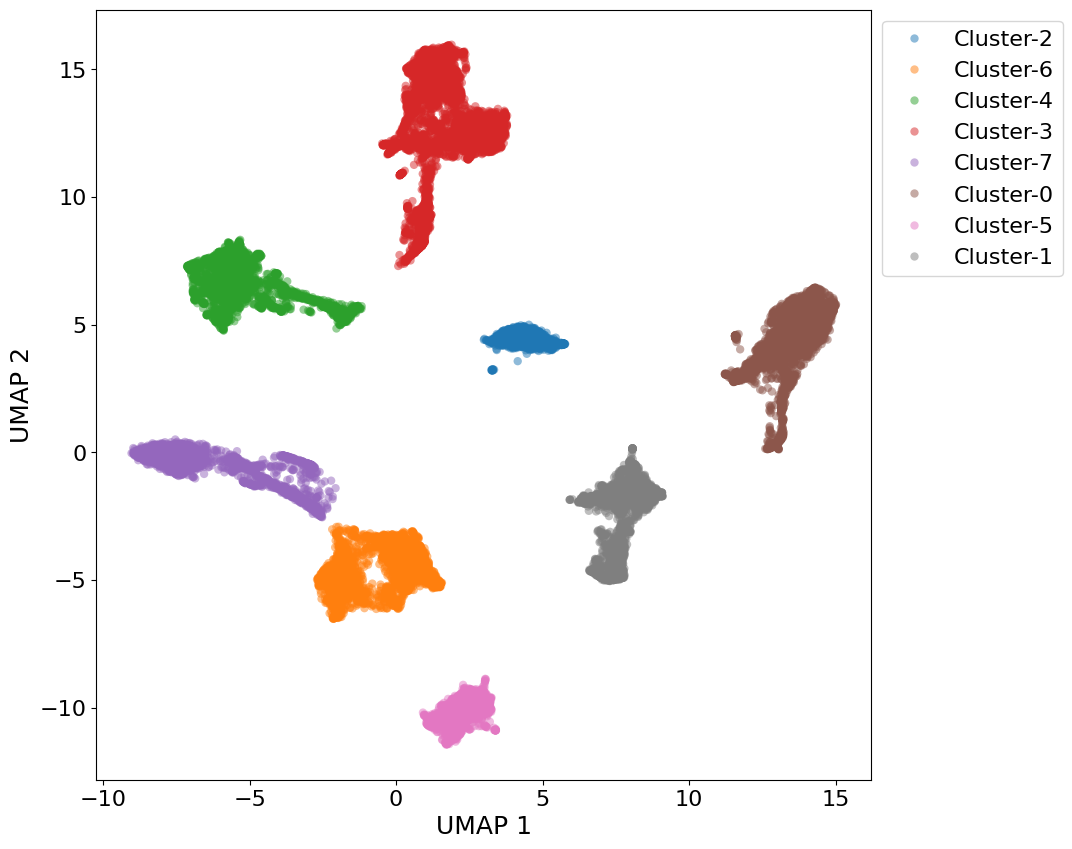

In [ ]:
plot_umap(embedding[clusters!=-1], [f"Cluster-{x}" for x in clusters[clusters!=-1]])

In [ ]:
read_cluster = np.array([[r, c] for r, c in zip(sample_idx, clusters) if c!=-1])

In [ ]:
np.savez(exp + 'data.npz', edges=edges, scaled=scaled, read_cluster=read_cluster)

In [ ]:
# !cp /content/test_data/edges.npy /content/drive/MyDrive/test_data_zymo
# !cp /content/test_data/edges.txt /content/drive/MyDrive/test_data_zymo
# !cp /content/test_data/data.npz /content/drive/MyDrive/test_data_zymo